In [3]:
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import calculate_option_price, calculate_r
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import cov_estimated_IV,cov_actual_IV
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

## Interest Rates

In [2]:
rates = pd.read_csv('../data/USTREASURY-YIELD_01_11_22.csv')

In [3]:
rates['Date'] = pd.to_datetime(rates['Date'],format='%Y-%m-%d')

In [4]:
rates = rates.set_index('Date')
rates = rates.asfreq('D')
rates = rates.ffill()

In [5]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11991 entries, 1990-01-02 to 2022-10-31
Freq: D
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1 MO    7763 non-null   float64
 1   2 MO    1477 non-null   float64
 2   3 MO    11991 non-null  float64
 3   6 MO    11991 non-null  float64
 4   1 YR    11991 non-null  float64
 5   2 YR    11991 non-null  float64
 6   3 YR    11991 non-null  float64
 7   5 YR    11991 non-null  float64
 8   7 YR    11991 non-null  float64
 9   10 YR   11991 non-null  float64
 10  20 YR   10623 non-null  float64
 11  30 YR   11991 non-null  float64
dtypes: float64(12)
memory usage: 1.2 MB


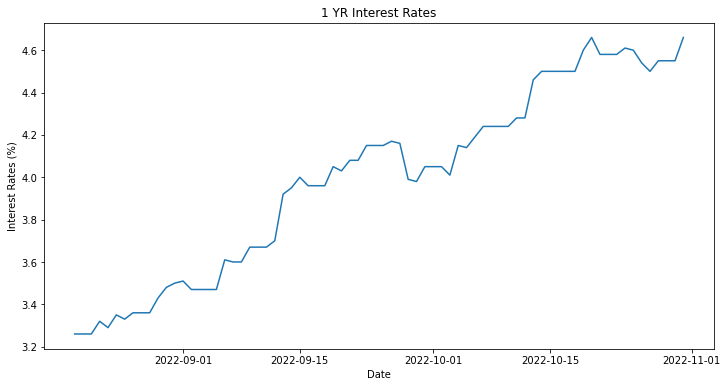

In [6]:
fig = plt.figure(figsize=(12,6))
plt.plot(rates.loc['2022-08-19':, '1 YR'])
plt.xlabel('Date')
plt.ylabel('Interest Rates (%)')
plt.title('1 YR Interest Rates')
plt.savefig('../results/1YR_interest_rates')

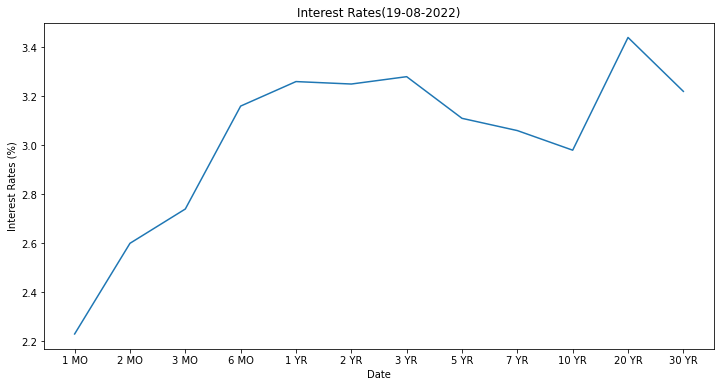

In [7]:
fig = plt.figure(figsize=(12,6))
plt.plot(rates.loc['2022-08-19', ])
plt.xlabel('Date')
plt.ylabel('Interest Rates (%)')
plt.title('Interest Rates(19-08-2022)')
plt.show()

In [15]:
day_map = {'1 MO': 30, '2 MO': 60, '3 MO': 90, '6 MO': 180, '1 YR': 365.25, '2 YR': 730.5, '3 YR': 1095.75}

In [16]:
temp = rates.loc['2022-08-19',]

In [18]:
temp_1 = {}
for i in day_map.keys():
    temp_1[day_map[i]] = temp.to_dict()[i]

In [19]:
temp_1

{30: 2.23,
 60: 2.6,
 90: 2.74,
 180: 3.16,
 365.25: 3.26,
 730.5: 3.25,
 1095.75: 3.28}

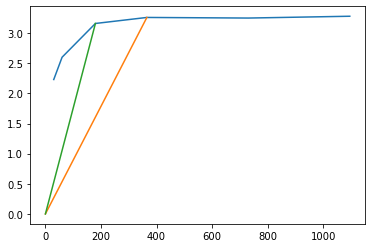

In [22]:
x,y = [], []
for i, j in temp_1.items():
    x.append(i)
    y.append(j)
plt.plot(x,y)
plt.plot([0,365.25], [0,3.26])
plt.plot([0,180], [0,3.16])

In [61]:
temp.index.map(days)

Float64Index([30.0, 60.0, 90.0, 180.0, 365.25, 730.5, 1095.75, nan, nan, nan,
              nan, nan],
             dtype='float64')

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-21 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
1002.7324766485191
trading_days_to_simulate: 251
Derivative Price for 2022-08-22 00:00:00
986.5351700673818
trading_days_to_simulate: 250
Derivative Price for 2022-08-23 00:00:00
980.8515566962736
trading_days_to_simulate: 249
Derivative Price for 2022-08-24 00:00:00
992.3272892005026
trading_days_to_simulate: 248
Derivative Price for 2022-08-25 00:00:00
1007.5351457860663
trading_days_to_simulate: 247
Derivative Price for 2022-08-26 00:00:00
993.3572863746216
trading_days_to_simulate: 244
Derivative Price for 2022-08-29 00:00:00
962.371713202496
trading_days_to_simulate: 243
D

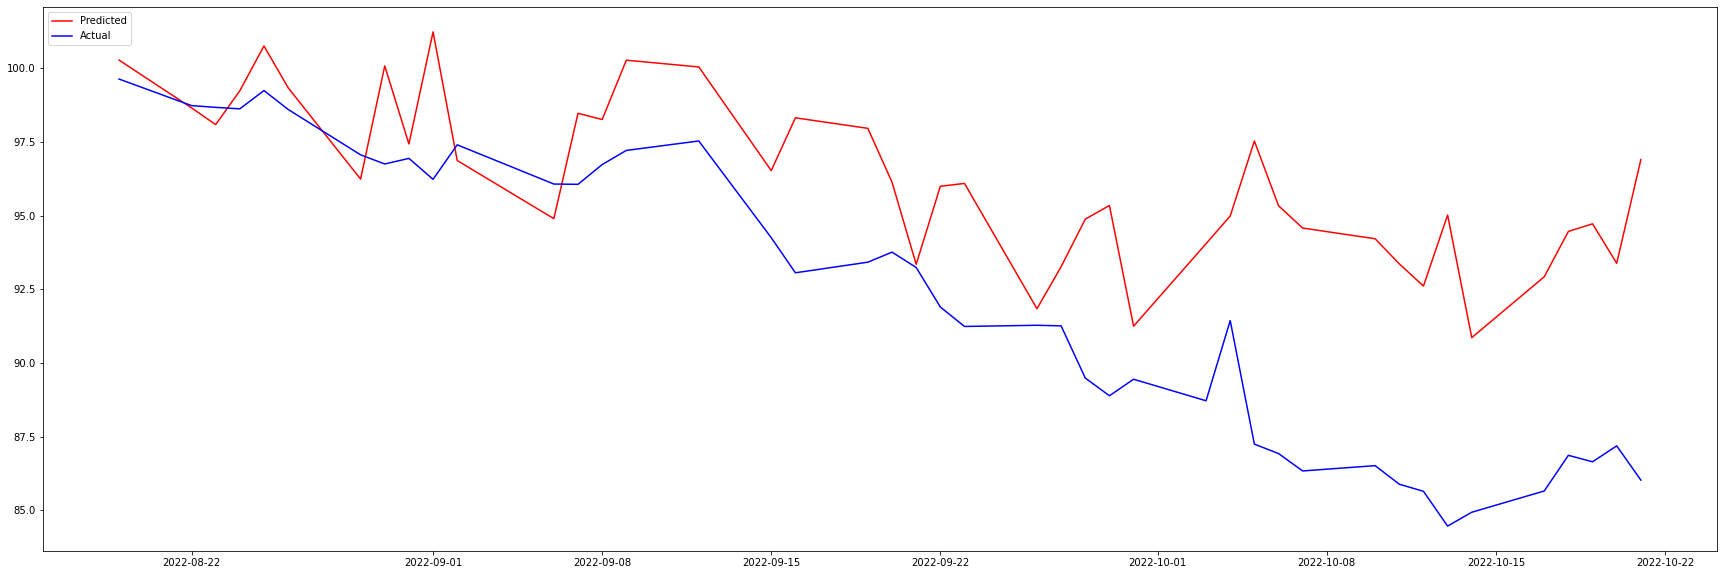

In [51]:
# experiment_details = {
#     'Nsim': 1000,
#     'latest_price_date': '2022-10-21',
#     'variance_reduction': True,
#     'GBM': 'multivariate',
# #     'r': rates,
#     'IV': False,
#     'min_sigma':0.0001,
#     'max_sigma':5,
#     'step':0.00001,
#     'error':0.25,
#     'EMS': True,
#     'interpolate_r': True
# }

# aapl_barrier = 85.760
# amzn_barrier = 69.115
# googl_barrier = 58.605
# aapl_initial = 171.52
# amzn_initial = 138.23
# google_initial = 117.21

# date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
#     latest_price_date=experiment_details['latest_price_date'])

# print(f"date_to_predict: {date_to_predict}")
# print(f"hist_end: {hist_end}")
# print(f"end_date: {end_date}")
# print(f"q2_to_maturity: {q2_to_maturity}")
# print(f"q3_to_maturity: {q3_to_maturity}")
# print(f"q2: {q2}")
# print(f"q3: {q3}")
# print(f"total_trading_days: {total_trading_days}")
# print(f"holidays: {holidays}")
# trading_days_to_simulate = total_trading_days

# if experiment_details['IV']:

#     aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
#     aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
#     amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
#     amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
#     googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
#     googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

#     min_sigma = experiment_details['min_sigma']
#     max_sigma = experiment_details['max_sigma']
#     error = experiment_details['error']
#     step = experiment_details['step']
#     sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
#     right = len(sigma_hat_list)-1
#     left = 0 

# predicted_option_price = []
# expected_payoff_list = []
# aapl_IV_list = []
# amzn_IV_list = []
# googl_IV_list = []

# while date_to_predict <= end_date:

#     if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
#         date_to_predict += relativedelta(days=+1)
#         trading_days_to_simulate -= 1
#         hist_end += relativedelta(days=+1)
#         alternative_option_ttm-=1
#         continue

#     hist_start = hist_end - timedelta(days=365)

#     aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
#     amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
#     googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
#     temp_df = aapl.merge(amzn, on=['Date'])
#     AAG = temp_df.merge(googl, on=['Date'])
#     n0 = len(AAG)
#     AAGprices = np.array(AAG.drop(columns=['Date']))
#     AAGlogprices = np.log(AAGprices)
#     AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

#     v = np.mean(AAGlogreturns, axis=0)
#     Nsim = experiment_details['Nsim']
#     T = trading_days_to_simulate
#     dt = 1
#     m = int(T / dt)
#     r = calculate_r(0, date_to_predict, interpolate_r=False)
#     experiment_details[f'r_{date_to_predict.strftime("%Y-%m-%d")}'] = r


#     # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
#     if experiment_details['IV']:
#         sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
#         aapl_IV_list.append(aapl_IV)
#         amzn_IV_list.append(amzn_IV)
#         googl_IV_list.append(googl_IV)
#     else:
#         sigma = np.cov(AAGlogreturns,rowvar=False)

#     print(f"trading_days_to_simulate: {trading_days_to_simulate}")

#     S0 = AAGprices[0, :]
#     sim_aapl = []
#     sim_amzn = []
#     sim_googl = []

#     # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
#     if experiment_details['variance_reduction']:
#         for i in range(1, int(Nsim/2) + 1):
#             S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
#             sim_aapl.append(S[0])
#             sim_aapl.append(Stilde[0])
#             sim_amzn.append(S[1])
#             sim_amzn.append(Stilde[1])
#             sim_googl.append(S[2])
#             sim_googl.append(Stilde[2])

#     else:
#         for i in range(1, Nsim + 1):
#             S,Z = SimMultiGBM(S0, v, sigma, dt, T)
#             sim_aapl.append(S[0])
#             sim_amzn.append(S[1])
#             sim_googl.append(S[2])

#     if experiment_details['EMS']:
#         sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
#         sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
#         sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

#     q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
#     q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None
    
#     option_prices = []
#     payoff_list = []
#     for i in range(Nsim):
#         option_price, payoff = calculate_option_price(
#                 aapl=sim_aapl[i],
#                 amzn=sim_amzn[i],
#                 googl=sim_googl[i],
#                 T=trading_days_to_simulate,
#                 total_trading_days=total_trading_days,
#                 r=r,
#                 q2_index=q2_index,
#                 q3_index=q3_index,
#                 interpolate_r=experiment_details['interpolate_r']
#             )
#         option_prices.append(
#             option_price
#         )
#         payoff_list.append(payoff)

#     expected_payoff_list.append(np.mean(payoff_list))
#     option_price = np.mean(option_prices)
#     predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#     print(f"Derivative Price for {date_to_predict}")
#     print(option_price)

#     date_to_predict += relativedelta(days=+1)
#     trading_days_to_simulate -= 1
#     hist_end += relativedelta(days=+1)
#     alternative_option_ttm-=1


# predicted_option_price = pd.DataFrame(predicted_option_price)
# predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# # Scale back to 100%
# predicted_option_price['predicted'] = predicted_option_price['predicted']/10
# actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
# actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
# combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
# combined = combined.set_index('date')


# evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

In [2]:
experiment_details = {
    'Nsim': 250,
    'latest_price_date': '2022-10-21',
    'variance_reduction': True,
    'GBM': 'multivariate',
#     'r': 0.0326,
    'IV': False,
    'min_sigma':0.0001,
    'max_sigma':5,
    'step':0.00001,
    'error':0.25,
    'EMS': True,
    'interpolate_r': True
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['IV']:

    aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
    aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
    amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
    amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
    googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
    googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    error = experiment_details['error']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

predicted_option_price = []
expected_payoff_list = []
aapl_IV_list = []
amzn_IV_list = []
googl_IV_list = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
#         trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
#         alternative_option_ttm-=1
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)
    


    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['IV']:
        sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(
            aapl_call_option_df,
            amzn_call_option_df,
            googl_call_option_df,
            r,
            alternative_option_ttm,
            sigma_hat_list,
            left,
            right,
            error,
            date_to_predict,
            AAGlogreturns
        )
        aapl_IV_list.append(aapl_IV)
        amzn_IV_list.append(amzn_IV)
        googl_IV_list.append(googl_IV)
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None
    
    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None
            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    
    # experiment_details[f'r_{date_to_predict.strftime("%Y-%m-%d")}'] = r
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-21 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']


/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last']=data['Close/Last'].str.replace('$','')
/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/Last']=data['Close/Last'].str.replace('$','')
/Users/siuu/dev/CZ4518-Simulation-in-Finance/python/utils/extract_data_function.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Close/La

trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
1002.2308709837787


NameError: name 'relativedelta' is not defined

In [4]:
experiment_details

{'Nsim': 250,
 'latest_price_date': '2022-10-21',
 'variance_reduction': True,
 'GBM': 'multivariate',
 'IV': False,
 'min_sigma': 0.0001,
 'max_sigma': 5,
 'step': 1e-05,
 'error': 0.25,
 'EMS': True,
 'interpolate_r': True,
 'r_2022-08-19': 0.031626990553306346,
 'r_2022-08-22': 0.03319878542510121,
 'r_2022-08-23': 0.03289460188933874,
 'r_2022-08-24': 0.032799999999999996,
 'r_2022-08-25': 0.033285964912280704,
 'r_2022-08-26': 0.03251777777777778,
 'r_2022-08-29': 0.03425695006747639,
 'r_2022-08-30': 0.03287333333333334,
 'r_2022-08-31': 0.03491012145748988,
 'r_2022-09-01': 0.03500593792172739,
 'r_2022-09-02': 0.034614979757085024,
 'r_2022-09-06': 0.033479999999999996,
 'r_2022-09-07': 0.03365555555555556,
 'r_2022-09-08': 0.035030499325236164,
 'r_2022-09-09': 0.03655222672064777,
 'r_2022-09-12': 0.03683940620782726,
 'r_2022-09-13': 0.03899581646423751,
 'r_2022-09-14': 0.039261538461538466,
 'r_2022-09-15': 0.039712010796221324,
 'r_2022-09-16': 0.036243333333333336,
 'r_2

In [11]:
experiment_details

{'Nsim': 1000,
 'latest_price_date': '2022-10-21',
 'variance_reduction': True,
 'GBM': 'multivariate',
 'IV': True,
 'min_sigma': 0.0001,
 'max_sigma': 5,
 'step': 1e-05,
 'error': 0.25,
 'EMS': True,
 'r_2022-08-19': 0.0326,
 'r_2022-08-22': 0.032598650472334685,
 'r_2022-08-23': 0.03160539811066127,
 'r_2022-08-24': 0.03258785425101214,
 'r_2022-08-25': 0.03258245614035088,
 'r_2022-08-26': 0.032577058029689604,
 'r_2022-08-29': 0.03136666666666667,
 'r_2022-08-30': 0.03255546558704453,
 'r_2022-08-31': 0.03255006747638327,
 'r_2022-09-01': 0.032544669365722,
 'r_2022-09-02': 0.032539271255060724,
 'r_2022-09-06': 0.03251767881241565,
 'r_2022-09-07': 0.03251228070175439,
 'r_2022-09-08': 0.030900000000000004,
 'r_2022-09-09': 0.032501484480431844,
 'r_2022-09-12': 0.03248529014844804,
 'r_2022-09-13': 0.03247989203778678,
 'r_2022-09-14': 0.03247449392712551,
 'r_2022-09-15': 0.030573333333333338,
 'r_2022-09-16': 0.03195087719298246,
 'r_2022-09-19': 0.032447503373819166,
 'r_2022